In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
connection = sqlite3.connect('../data/checking-logs.sqlite')

## Данные о комитах

In [3]:
query = """
SELECT 
    timestamp,
    CAST(strftime('%w', timestamp) AS INTEGER) as weekday,
    CAST(strftime('%H', timestamp) AS INTEGER) as hour
FROM checker
WHERE uid LIKE 'user%'
"""
df = pd.read_sql(query, connection)

## Классификация дней на рабочие и выходные

In [4]:
df['day_type'] = 'working_day'
df.loc[df['weekday'].isin([0, 6]), 'day_type'] = 'weekend'

## Группируем по часу и типу дня

In [5]:
counts = df.groupby(['hour', 'day_type']).size().unstack()

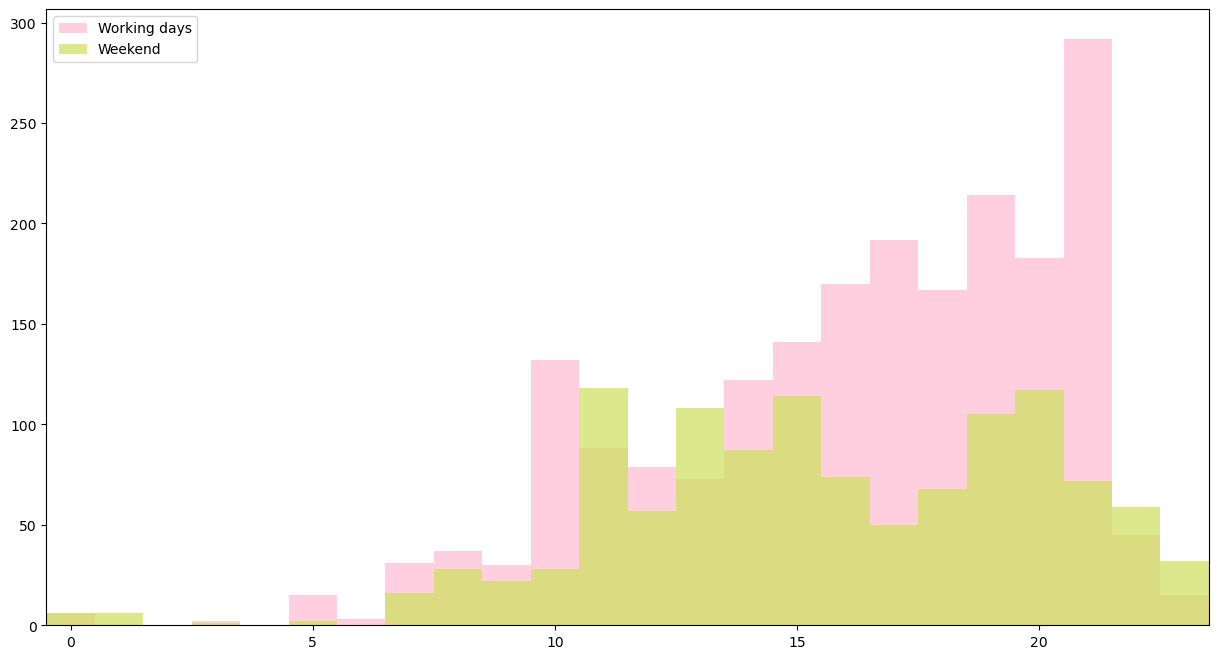

In [6]:
plt.figure(figsize=(15, 8))

# Гистограмма рабочих дней
plt.bar(
    counts.index, 
    counts['working_day'],
    width=1.0,
    color="#FFBBD4",
    alpha=0.7,
    label='Working days',
    edgecolor='none'
)

# Гистограмма выходных
plt.bar(
    counts.index,
    counts['weekend'],
    width=1.0,
    color="#CDE15B",
    alpha=0.7,
    label='Weekend',
    edgecolor='none'
)

plt.legend(fontsize=10, loc='upper left')
plt.xlim(-0.5, 23.5)
plt.xticks(
    ticks=range(0, 25, 5),
    labels=range(0, 25, 5),
    rotation=0
)

plt.show()

## Бывают ли часы, когда общее количество коммитов в выходные дни было выше, чем в рабочие дни?

In [7]:
commit_comparison = counts.rename(columns={'working_day': 'work_days', 'weekend': 'weekend_days'})
weekend_higher = commit_comparison[commit_comparison['weekend_days'] > commit_comparison['work_days']]
top_weekend_hours = weekend_higher.nlargest(4, 'weekend_days')

print("Четыре лучших примера:")
print("-" * 40)
for hour, data in top_weekend_hours.iterrows():
    print(f"• Час {hour:02d}:00:")
    print(f"  Выходные: {data['weekend_days']} коммитов")
    print(f"  Рабочие дни: {data['work_days']} коммитов")
    print(f"  Разница: +{data['weekend_days'] - data['work_days']}")
    print("-" * 40)

Четыре лучших примера:
----------------------------------------
• Час 11:00:
  Выходные: 118.0 коммитов
  Рабочие дни: 88.0 коммитов
  Разница: +30.0
----------------------------------------
• Час 13:00:
  Выходные: 108.0 коммитов
  Рабочие дни: 73.0 коммитов
  Разница: +35.0
----------------------------------------
• Час 22:00:
  Выходные: 59.0 коммитов
  Рабочие дни: 45.0 коммитов
  Разница: +14.0
----------------------------------------
• Час 23:00:
  Выходные: 32.0 коммитов
  Рабочие дни: 15.0 коммитов
  Разница: +17.0
----------------------------------------


In [8]:
connection.close()